### Imports

In [24]:
# Remove unwanted warnings

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data extraction and management
import pandas as pd
import numpy as np
import yfinance as yf

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# Cointegration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from pandas_datareader.data import DataReader
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols


%matplotlib inline

### Data Extraction

In [25]:
# Set Data Extraction parameters
start_date = "2022-01-01"
end_date = "2025-06-01"
file_name = "data/raw_data_etf.csv"
file_name_coint = "data/raw_data_coint_pairs.csv"

load_existing = True
load_coint_pairs = True

    

In [26]:
# Get New or Load Existing Data
# Takes a long time
symbols = None
if not load_existing:
    symbols = get_nasdaq_symbols()
    symbols = symbols[(symbols["ETF"] == True) & (symbols["Market Category"] == "G")] # G = NASDAQ GLOBAL MARKET
    symbols = list(symbols.index.values)
    df = pd.DataFrame()
    data = yf.download(symbols, start=start_date, end=end_date)["Close"]
    data.to_csv(file_name)

In [27]:
# Load (or re-load for consistency) Data and remove features with NaN's
data = pd.read_csv(file_name)
data.dropna(axis=1, inplace=True)
data = data.set_index("Date")
print("Shape: ", data.shape)
print("Null Vallues: ", data.isnull().values.any())
data.head()



Shape:  (855, 385)
Null Vallues:  False


,AADR,AAVM,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIQ,AIRR,...,VTWV,VWOB,VXUS,VYMI,WCBR,WCLD,WOOD,XOVR,XT,YLDE
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,60.547958,24.521076,78.096153,100.008400,50.674938,28.064827,18.941515,70.461159,31.578905,44.886452,...,137.374893,62.606052,57.461765,57.402676,25.503109,51.299999,85.437965,14.970,65.015892,40.110004
2022-01-04,60.529152,24.741039,77.777344,99.923759,50.765560,27.938366,18.921259,70.479462,31.083782,45.640682,...,138.495239,62.671188,57.533627,57.869431,24.447641,49.209999,85.596825,14.655,64.134926,40.400589
2022-01-05,59.551517,24.374435,76.483406,98.296776,50.212776,27.409168,18.937468,69.069153,30.014317,44.509342,...,135.302216,61.930218,56.958824,57.648777,23.359194,46.299999,84.802528,13.970,62.382763,40.400589
2022-01-06,59.842930,24.308449,76.849091,98.089867,50.158401,26.941259,18.949615,69.572838,30.004416,44.866600,...,136.338547,61.881390,56.797165,57.793049,23.405170,46.619999,85.176308,13.994,62.069530,39.955032
2022-01-07,59.842930,24.259874,77.571068,98.071060,50.384953,26.986984,18.917215,70.351265,29.885586,44.089546,...,135.769043,61.710407,57.048641,58.412563,23.329206,46.270000,85.783714,13.798,61.638832,40.086945


### Feature Engineering

In [28]:
# Create DataFrame with Returns and Volatiltity information
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=["Returns"])
df_returns["Volatility"] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,Returns,Volatility
AADR,0.098191,0.223337
AAVM,0.034461,0.175080
AAXJ,0.016452,0.205587
ACWI,0.076589,0.176438
ACWX,0.058376,0.171996


In [29]:
# Scale Features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
AADR,0.833750,0.192934
AAVM,-0.107131,-0.208640
AAXJ,-0.373009,0.045229
ACWI,0.514822,-0.197339
ACWX,0.245936,-0.234298


### K-Means Clustering

In [30]:
# Find the optimum number of clusters
X = df_scaled.copy()
K = range(1, 15)
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
c = kl.elbow
print("Optimum Clusters: ", c)

Optimum Clusters:  5


In [31]:
# Fit K-Means Model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

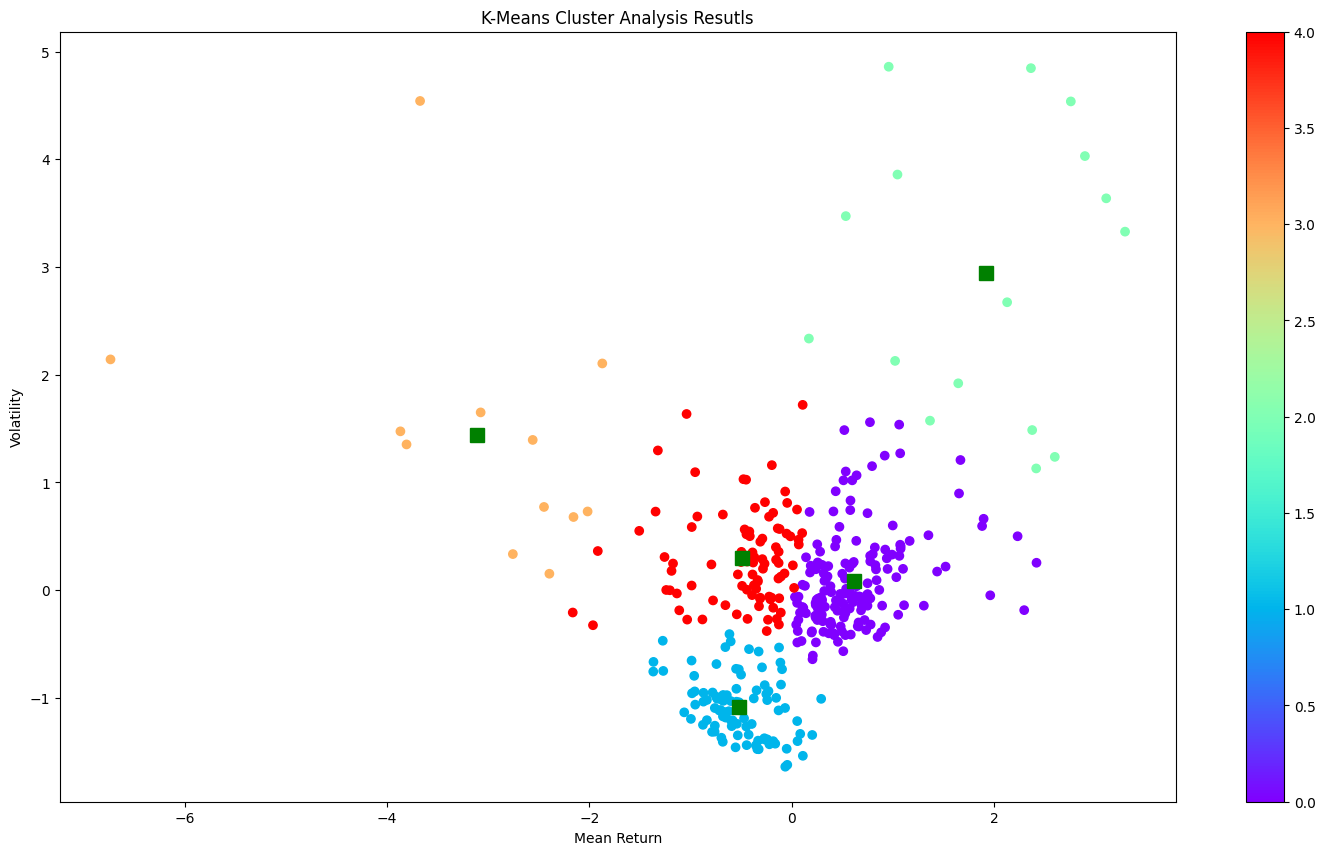

In [32]:
# Show Results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label=X.index)
ax.set_title("K-Means Cluster Analysis Resutls")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)

In [33]:
# Return the series
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series[:15]

AADR    0
AAVM    4
AAXJ    4
ACWI    0
ACWX    0
AGNG    0
AGZD    1
AIA     4
AIQ     0
AIRR    0
ALTY    1
ANGL    1
AQWA    0
ASET    4
BBH     4
dtype: int32

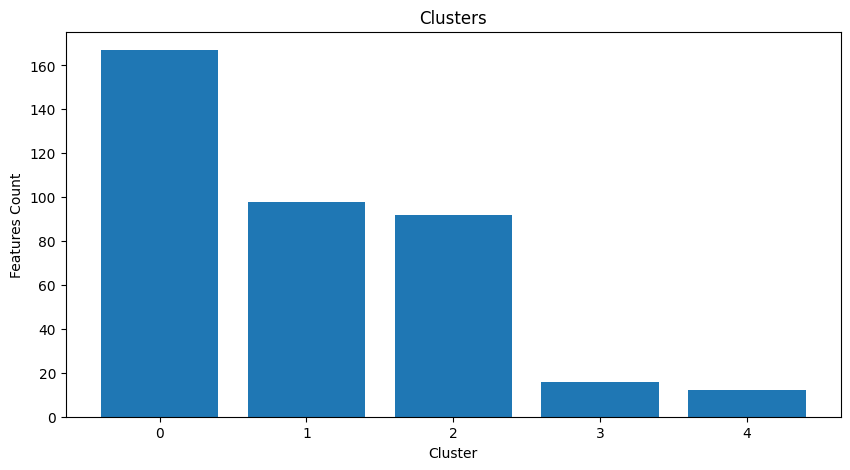

In [34]:
plt.figure(figsize=(10,5))
plt.bar(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Features Count")
plt.show()

In [35]:
# Remvoe Items if Preferred
clusters_clean = clustered_series[clustered_series < 3]
print("Feature Number Previous: ", len(clustered_series))
print("Feature Number Current: ", len(clusters_clean))

Feature Number Previous:  385
Feature Number Current:  281


### Calculate Cointegration

In [36]:
def calculate_cointegration(series_1, series_2):
    coint_flag = 0
    coint_res = coint(series_1, series_2)
    coint_t = coint_res[0]
    p_value = coint_res[1]
    critical_value = coint_res[2][1]
    model = sm.OLS(series_1, series_2).fit()
    hedge_ratio = model.params[0]
    coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
    return coint_flag, hedge_ratio
    

In [37]:
# Loop through and calculate cointegrate pairs

tested_pairs = []
cointegrated_pairs = []
if not load_coint_pairs:
    for base_asset in clusters_clean.index:
        base_label = clusters_clean[base_asset]
        for compare_asset in clusters_clean.index:
            compare_label = clusters_clean[compare_asset]

            test_pair = base_asset + compare_asset
            test_pair = ''.join(sorted(test_pair))
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)

            if compare_asset != base_asset and base_label == compare_label and not is_tested:

                series_1 = data[base_asset].values.astype(float)
                series_2 = data[compare_asset].values.astype(float)
                coint_flag, _ = calculate_cointegration(series_1, series_2)
                if coint_flag == 1:
                    cointegrated_pairs.append({
                        "base asset": base_asset,
                        "compare asset": compare_asset,
                        "label": base_label})
    df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
    df_coint.to_csv(file_name_coint)
                    

In [39]:
# Load cointegrated pairs from scratch
if load_coint_pairs:
    df_coint = pd.read_csv(file_name_coint)
    df_coint = df_coint.iloc[:, 1:]
df_coint.head()
    

,base asset,compare asset,label
0,BIS,TUR,0
1,DAPP,SKYU,0
2,DAPP,QQQH,0
3,SMH,TQQQ,0
4,BITS,SKYU,0


### TSNE Plot for Visualization

In [41]:
# Get a unique list of cointegrated assets
coint_assets = [df_coint["base asset"].values]
coint_assets.append(df_coint["compare asset"].values)
coint_unique_assets = np.unique(coint_assets)
coint_unique_assets[:5]

array(['AADR', 'ACWI', 'ACWX', 'AGNG', 'AIQ'], dtype=object)

In [44]:
df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coint_unique_assets)]
df_TSNE.head()

,Returns,Volatility
AADR,0.833750,0.192934
ACWI,0.514822,-0.197339
ACWX,0.245936,-0.234298
AGNG,0.045142,-0.320463
AIQ,0.999538,0.600358


In [47]:
# Compute TSNE
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(df_TSNE)
X_tsne[:5]

array([[-22.294037 ,  -5.42221  ],
       [  5.2817473, -21.128054 ],
       [ 30.645771 , -16.146915 ],
       [ 47.15641  , -19.559908 ],
       [-29.502317 ,   5.059323 ]], dtype=float32)

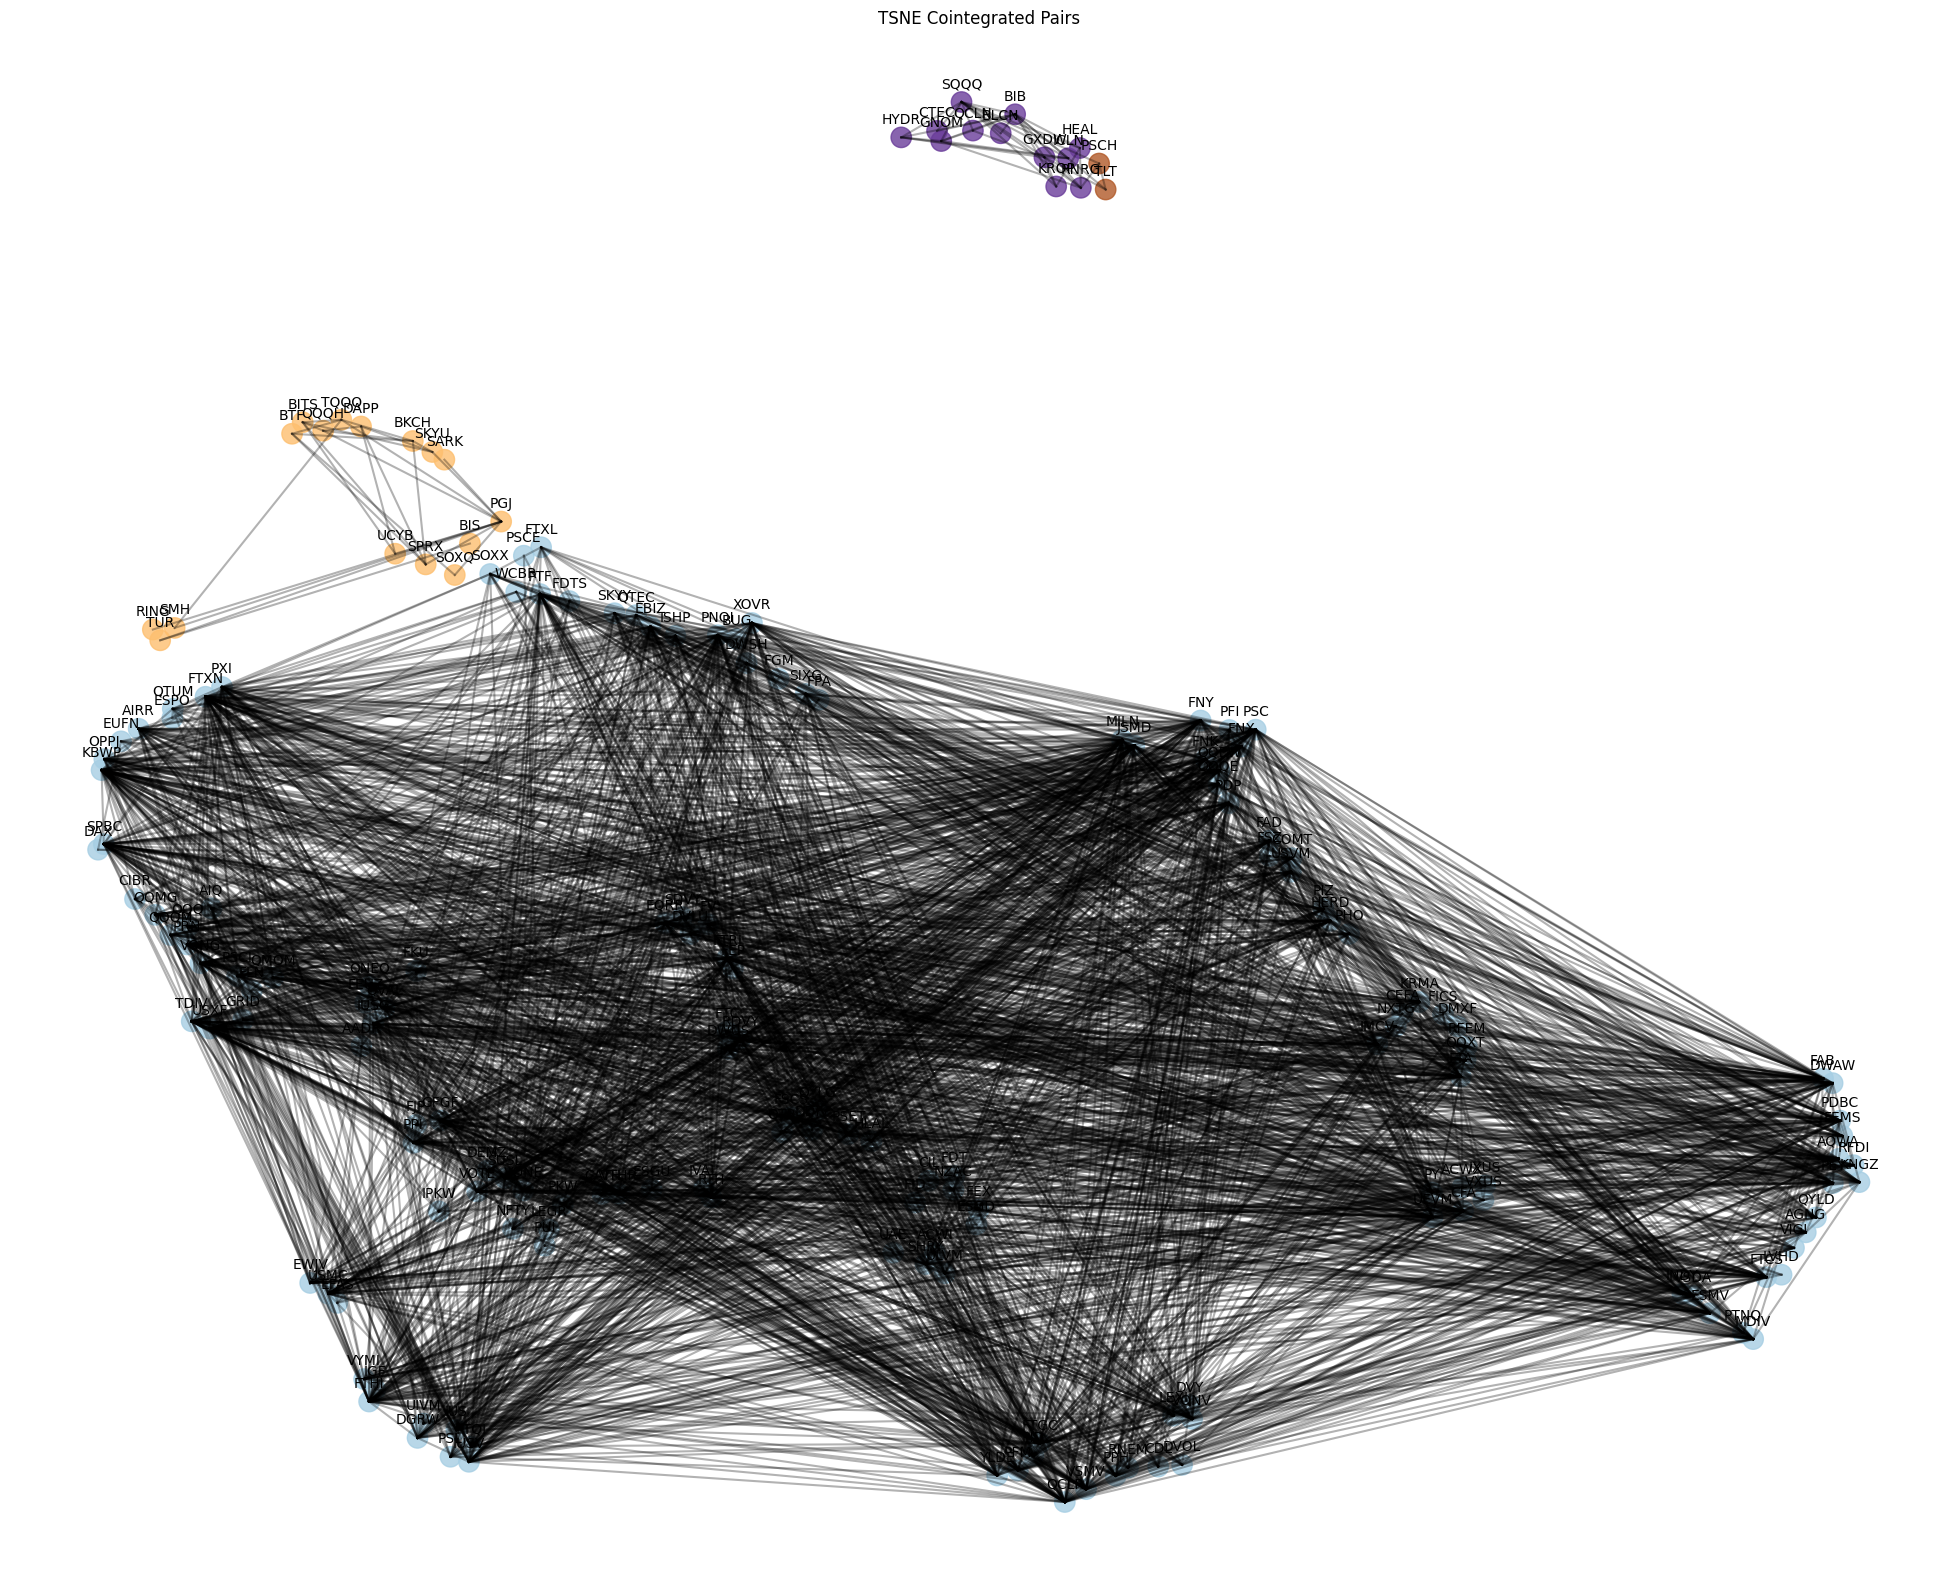

In [52]:
# Preview TSNE
in_pairs_series = clustered_series.loc[coint_unique_assets]
plt.figure(1, figsize=(25,20))
plt.clf()
plt.axis('off')
for index, pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)

plt.scatter(X_tsne[:, 0], X_tsne[:,1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Cointegrated Pairs')

#Show TSNE Plot
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], df_TSNE.index):
    label = name
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha="center")
plt.show()


### Review a Pair

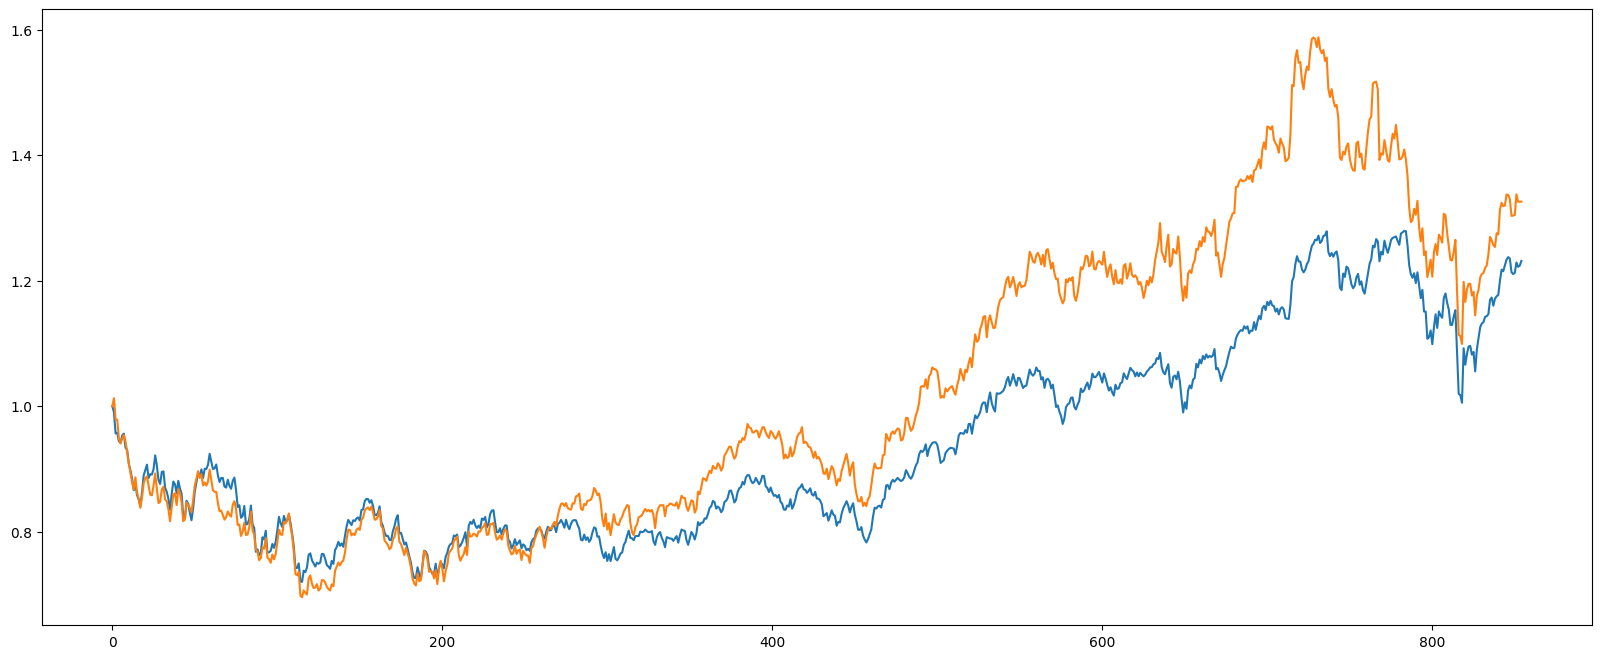

In [56]:
# Plot price comparison for any given assets
asset_1 = "FTC"
asset_2 = "PRN"

asset_1_values = data[asset_1].values / data[asset_1].iloc[0].item()
asset_2_values = data[asset_2].values / data[asset_2].iloc[0].item()
plt.figure(1, figsize=(20,8))
plt.plot(asset_1_values)
plt.plot(asset_2_values)
plt.show()

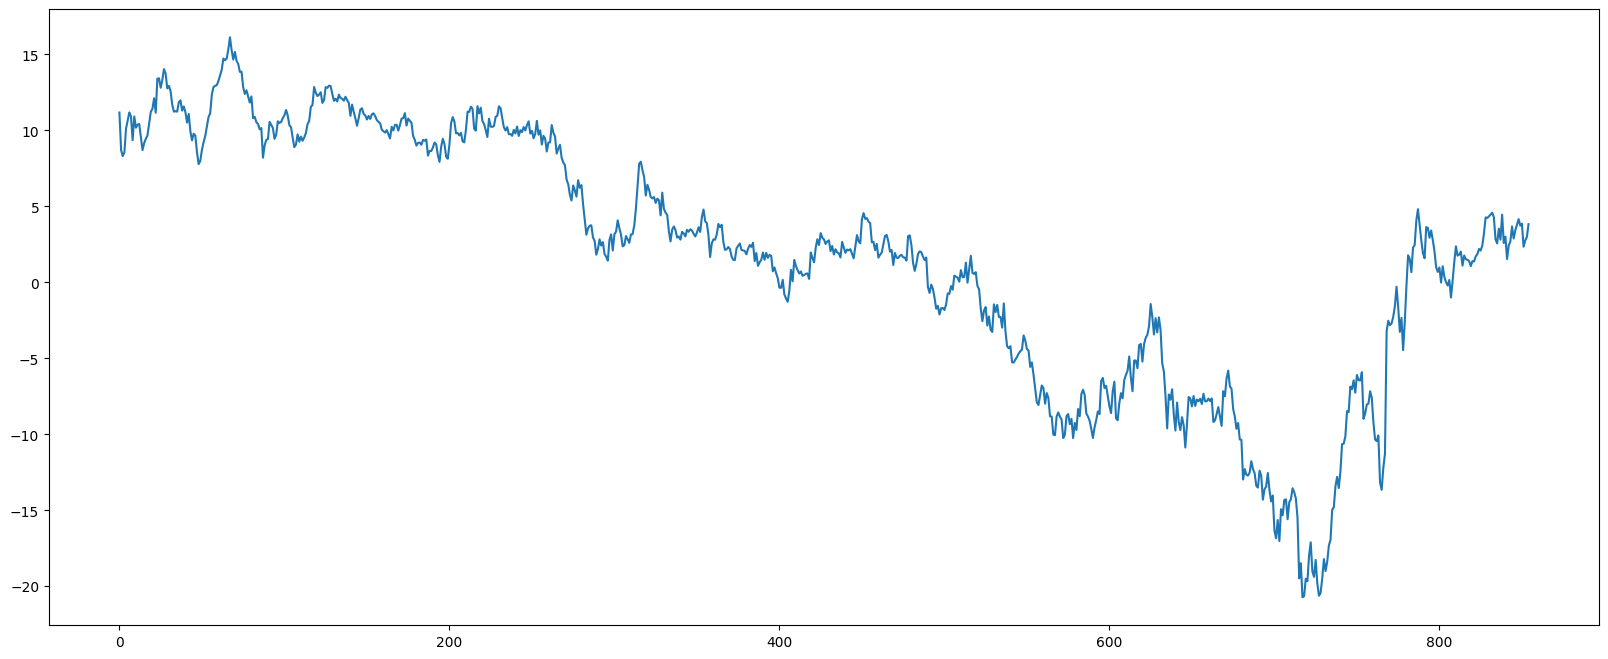

In [58]:
# Plot the Spread
series_1 = data[asset_1].values.astype(float)
series_2 = data[asset_2].values.astype(float)
coint_flag, hedge_ratio = calculate_cointegration(series_1, series_2)
spread = series_1 - (hedge_ratio * series_2)
plt.figure(1, figsize=(20,8))
plt.plot(spread)
plt.show()

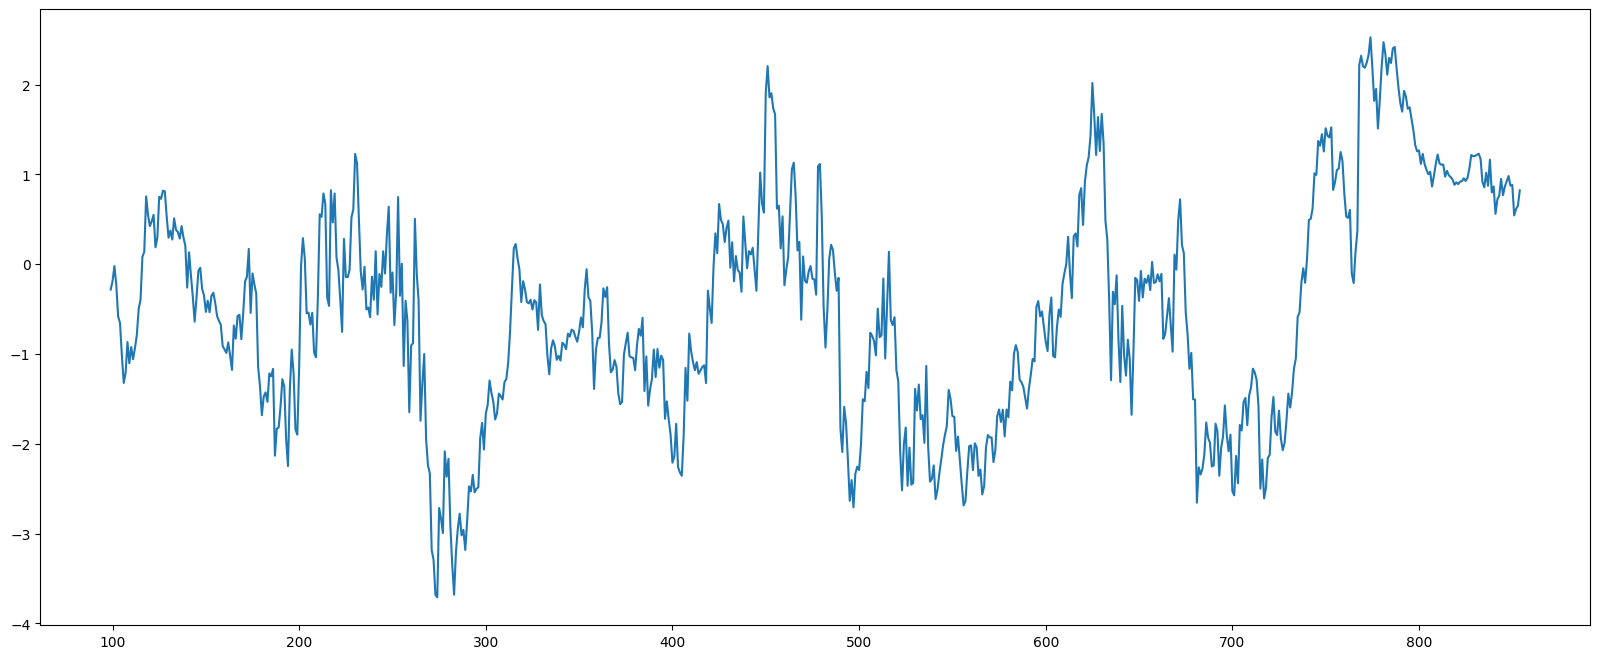

In [60]:
# Plot the ZScore
window = 100
spread_series = pd.Series(spread)
mean = spread_series.rolling(center=False, window=window).mean()
std = spread_series.rolling(center=False, window=window).std()
x = spread_series.rolling(center=False, window=1).mean()
z_score = (x - mean) / std
plt.figure(1, figsize=(20,8))
plt.plot(z_score)
plt.show()